<a href="https://colab.research.google.com/github/PLEX-GR00T/Data_Mining/blob/main/Transfer_Learning_3_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for 3 models
We, will explore three different models on the same dataset doing transfer learning and at the end we will compare them. We will perform all the tasks in the Tensorflow. 

In [267]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Loding the Data

In [268]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(
    'cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [269]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Below, we display a few instances in the dataset

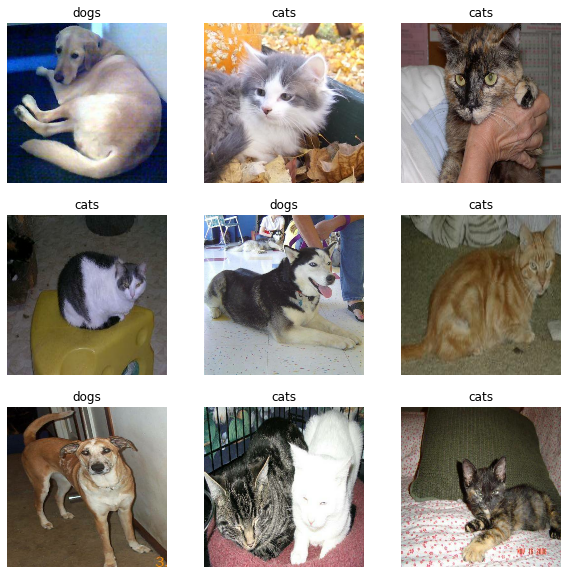

In [270]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Now we can split the dataset into two part as test and train in 20% and 80% ratio.

In [271]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [272]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [273]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Data Augmentation

In [274]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


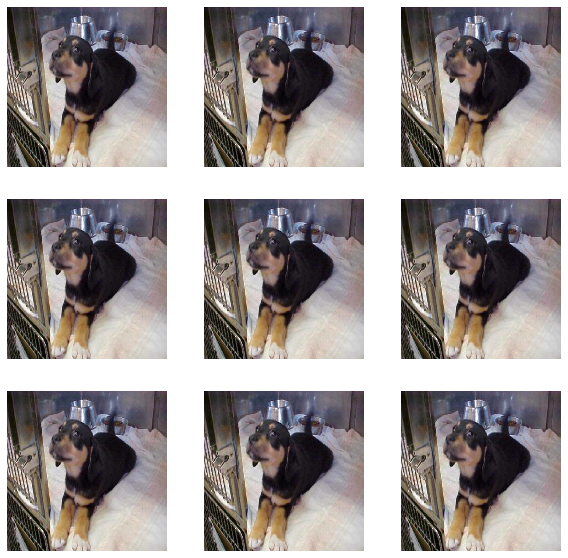

In [275]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


#Model 1: MobileNet V2

Now, we will implement our 1st model as MobileNet V2. This model's requirement is to have pixel values between [-1,1]. But, we have those values in [0,255] range. So, we will convert it.

In [276]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [277]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [278]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [279]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important because, we don't want our weights to be update, we want to use the updated and pre-trained weights.

In [280]:
base_model.trainable = False

Let's look at the model summary.

In [281]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_29[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification header and convert the features to single 1280-element vector



In [282]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Since we are doing a binary classification, our output layer has only one node.

In [283]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. We use training=False as our model contains a BatchNormalization layer.

In [284]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


Compile the model


In [285]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [286]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                          

Train the model

Before training the model, we observe the following accuracy.

In [287]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 34ms/step - loss: 0.7127 - accuracy: 0.5433


In [288]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.54



After training for 10 epochs, we see 96% accuracy on the validation set.

In [289]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 60ms/step - loss: 0.6232 - accuracy: 0.6310 - val_loss: 0.4982 - val_accuracy: 0.7450
Epoch 2/10
63/63 [==============================] - 4s 61ms/step - loss: 0.4684 - accuracy: 0.7635 - val_loss: 0.3684 - val_accuracy: 0.8304
Epoch 3/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3811 - accuracy: 0.8110 - val_loss: 0.2917 - val_accuracy: 0.8849
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3374 - accuracy: 0.8445 - val_loss: 0.2407 - val_accuracy: 0.9134
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2939 - accuracy: 0.8660 - val_loss: 0.2045 - val_accuracy: 0.9369
Epoch 6/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2674 - accuracy: 0.8840 - val_loss: 0.1843 - val_accuracy: 0.9356
Epoch 7/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2416 - accuracy: 0.8885 - val_loss: 0.1592 - val_accuracy: 0.9530
Epoch 8/10
63

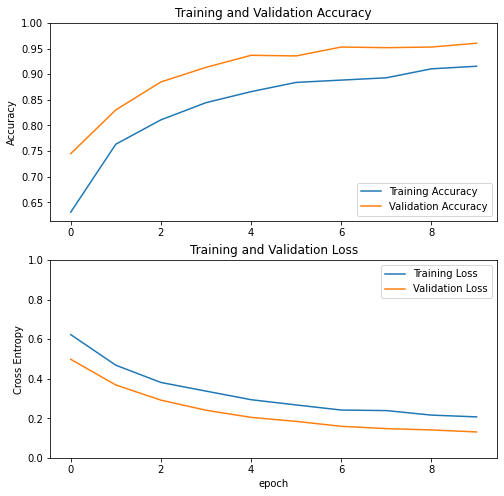

In [290]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Un-freeze the top layers of the model



All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [291]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [292]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [293]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 10s 79ms/step - loss: 0.1446 - accuracy: 0.9390 - val_loss: 0.0727 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1186 - accuracy: 0.9525 - val_loss: 0.0608 - val_accuracy: 0.9752
Epoch 12/20
63/63 [==============================] - 5s 67ms/step - loss: 0.1066 - accuracy: 0.9560 - val_loss: 0.0547 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 5s 68ms/step - loss: 0.0932 - accuracy: 0.9660 - val_loss: 0.0548 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 5s 69ms/step - loss: 0.0765 - accuracy: 0.9700 - val_loss: 0.0481 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0912 - accuracy: 0.9670 - val_loss: 0.0432 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 5s 68ms/step - loss: 0.0769 - accuracy: 0.9715 - val_loss: 0.0450 - val_accuracy: 0.9839
Epoch

In [294]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


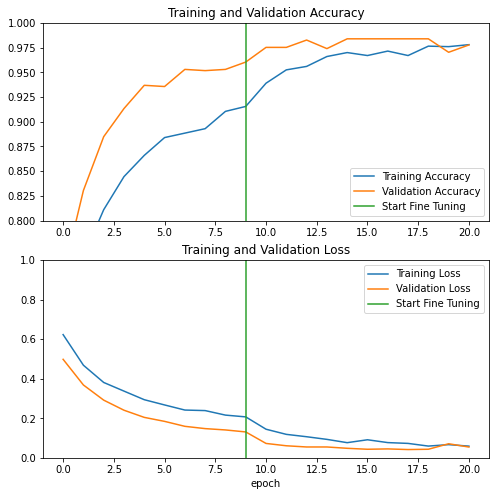

In [295]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [296]:
loss_, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 51ms/step - loss: 0.0454 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


#Model 2: MobileNetV3Large

In this section, we will be using the MobileNetV3Large network for transfer learning. We begin by preprocessing our images by rescaling them.

In [297]:
mv3_preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [298]:
# Create the base model from the pre-trained model vgg16
IMG_SHAPE = IMG_SIZE + (3,)
mv3_base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                 include_top=False,
                                                 weights='imagenet')

In [299]:
image_batch, label_batch = next(iter(train_dataset))
mv3_feature_batch = mv3_base_model(image_batch)
print(mv3_feature_batch.shape)


(32, 5, 5, 960)


We freeze the layers in the base model so that the pre-learnt weights are not disturbed.

In [300]:
mv3_base_model.trainable = False
mv3_base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 160, 160, 3)  0           ['input_31[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 80, 80, 16)   432         ['rescaling_6[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 80, 80, 16)  64          ['Conv[0][0]']    

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.



In [301]:
mv3_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
mv3_feature_batch_average = mv3_global_average_layer(mv3_feature_batch)
print(mv3_feature_batch_average.shape)

(32, 960)


Since we are doing a binary classification, our output layer has only one node.

In [302]:
mv3_prediction_layer = tf.keras.layers.Dense(1)
mv3_prediction_batch = mv3_prediction_layer(mv3_feature_batch_average)
print(mv3_prediction_batch.shape)


(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [303]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = mv3_preprocess_input(x)
x = mv3_base_model(x, training=False)
x = mv3_global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = mv3_prediction_layer(x)
mv3_model = tf.keras.Model(inputs, outputs)


Compile the model

Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [304]:
base_learning_rate = 0.0001
mv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [305]:
mv3_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_14  (None, 960)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 960)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 961

Train the model

Before training the model, we observe the following accuracy.

In [306]:
mv3_loss0, mv3_accuracy0 = mv3_model.evaluate(validation_dataset)

26/26 [==============================] - 3s 35ms/step - loss: 0.9492 - accuracy: 0.5149


In [307]:
print("initial loss: {:.2f}".format(mv3_loss0))
print("initial accuracy: {:.2f}".format(mv3_accuracy0))

initial loss: 0.95
initial accuracy: 0.51


In [308]:
initial_epochs = 10

mv3_history = mv3_model.fit(train_dataset,
                          epochs=initial_epochs,
                          validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 60ms/step - loss: 0.8117 - accuracy: 0.5585 - val_loss: 0.6538 - val_accuracy: 0.6126
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 0.6336 - accuracy: 0.6410 - val_loss: 0.5197 - val_accuracy: 0.7203
Epoch 3/10
63/63 [==============================] - 4s 61ms/step - loss: 0.5504 - accuracy: 0.7045 - val_loss: 0.4267 - val_accuracy: 0.7797
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.4612 - accuracy: 0.7620 - val_loss: 0.3605 - val_accuracy: 0.8168
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4177 - accuracy: 0.7910 - val_loss: 0.2976 - val_accuracy: 0.8540
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3707 - accuracy: 0.8225 - val_loss: 0.2731 - val_accuracy: 0.8911
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3307 - accuracy: 0.8500 - val_loss: 0.2414 - val_accuracy: 0.9084
Epoch 8/10
63

After training for 10 epochs, we see 93% accuracy on the validation set.

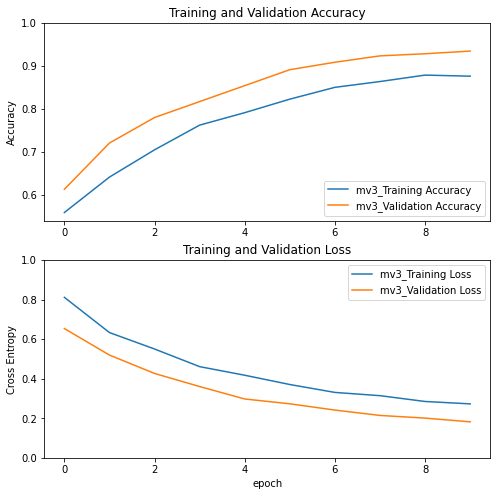

In [309]:
mv3_acc = mv3_history.history['accuracy']
mv3_val_acc = mv3_history.history['val_accuracy']

mv3_loss = mv3_history.history['loss']
mv3_val_loss = mv3_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mv3_acc, label='mv3_Training Accuracy')
plt.plot(mv3_val_acc, label='mv3_Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(mv3_loss, label='mv3_Training Loss')
plt.plot(mv3_val_loss, label='mv3_Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Fine tuning

In [310]:
mv3_base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mv3_base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mv3_base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  263


In [311]:
mv3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [312]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

mv3_history_fine = mv3_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=mv3_history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 12s 90ms/step - loss: 0.2100 - accuracy: 0.9085 - val_loss: 0.1169 - val_accuracy: 0.9592
Epoch 11/20
63/63 [==============================] - 5s 75ms/step - loss: 0.1561 - accuracy: 0.9435 - val_loss: 0.0880 - val_accuracy: 0.9666
Epoch 12/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1255 - accuracy: 0.9465 - val_loss: 0.0794 - val_accuracy: 0.9691
Epoch 13/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1150 - accuracy: 0.9565 - val_loss: 0.0708 - val_accuracy: 0.9728
Epoch 14/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0974 - accuracy: 0.9620 - val_loss: 0.0582 - val_accuracy: 0.9777
Epoch 15/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0990 - accuracy: 0.9610 - val_loss: 0.0536 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0782 - accuracy: 0.9715 - val_loss: 0.0581 - val_accuracy: 0.9802
Epoch

In [313]:
mv3_acc += mv3_history_fine.history['accuracy']
mv3_val_acc += mv3_history_fine.history['val_accuracy']

mv3_loss += mv3_history_fine.history['loss']
mv3_val_loss += mv3_history_fine.history['val_loss']


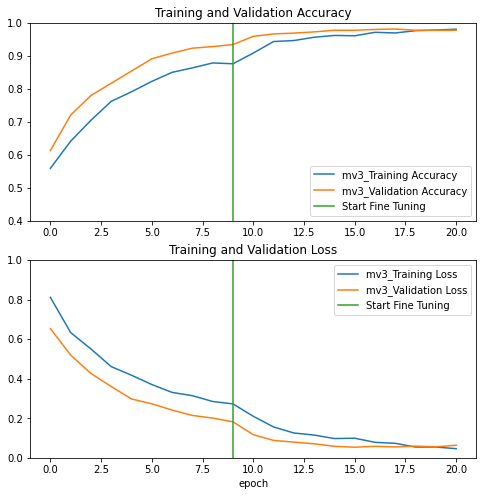

In [314]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mv3_acc, label='mv3_Training Accuracy')
plt.plot(mv3_val_acc, label='mv3_Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(mv3_loss, label='mv3_Training Loss')
plt.plot(mv3_val_loss, label='mv3_Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [315]:
mv3_loss_, mv3_accuracy = mv3_model.evaluate(test_dataset)
print('Test accuracy :', mv3_accuracy)

6/6 [==============================] - 1s 42ms/step - loss: 0.0179 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


#Model 3: Resnet50

In this section, we will be using the Resnet50 network for transfer learning. We begin by preprocessing our images by rescaling them.

In [316]:
rn5_preprocess_input = tf.keras.applications.resnet50.preprocess_input

We now proceed to loading the pretrained model. Notice that we exclude the top layer in the network. In Deep Learning literature, the diagrams are drawn bottom to top, and hence the top layer refers to the last layer in the network.

In [317]:
# Create the base model from the pre-trained model InceptionV3
IMG_SHAPE = IMG_SIZE + (3,)
rn5_base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                 include_top=False,
                                                 weights='imagenet')

Using transfer learning we can have our models learn more generalized feature extractors as these complex base models are trained on huge amounts of data. This feature extractor converts each 160x160x3 image into a 5x5x2048 block of features. Let's see what it does to an example batch of images:

In [318]:
image_batch, label_batch = next(iter(train_dataset))
rn5_feature_batch = rn5_base_model(image_batch)
print(rn5_feature_batch.shape)


(32, 5, 5, 2048)


We freeze the layers in the base model so that the pre-learnt weights are not disturbed.

In [319]:
rn5_base_model.trainable = False
rn5_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_33[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 512-element vector per image.



In [320]:
rn5_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
rn5_feature_batch_average = rn5_global_average_layer(rn5_feature_batch)
print(rn5_feature_batch_average.shape)


(32, 2048)


Since we are doing a binary classification, our output layer has only one node.

In [321]:
rn5_prediction_layer = tf.keras.layers.Dense(1)
rn5_prediction_batch = rn5_prediction_layer(rn5_feature_batch_average)
print(rn5_prediction_batch.shape)


(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [322]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rn5_preprocess_input(x)
x = rn5_base_model(x, training=False)
x = rn5_global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = rn5_prediction_layer(x)
rn5_model = tf.keras.Model(inputs, outputs)


Compile the model

Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [323]:
base_learning_rate = 0.0001
rn5_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])


In [324]:
rn5_model.summary()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_7   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_15  (None, 2048)             0  

Train the model

Before training the model, we observe the following accuracy.

In [325]:
rn5_loss0, rn5_accuracy0 = rn5_model.evaluate(validation_dataset)


26/26 [==============================] - 3s 60ms/step - loss: 0.6958 - accuracy: 0.5767


In [326]:
print("initial loss: {:.2f}".format(rn5_loss0))
print("initial accuracy: {:.2f}".format(rn5_accuracy0))


initial loss: 0.70
initial accuracy: 0.58


In [327]:
initial_epochs = 10

rn5_history = rn5_model.fit(train_dataset,
                          epochs=initial_epochs,
                          validation_data=validation_dataset)


Epoch 1/10
63/63 [==============================] - 9s 98ms/step - loss: 0.6263 - accuracy: 0.6815 - val_loss: 0.3273 - val_accuracy: 0.8292
Epoch 2/10
63/63 [==============================] - 6s 98ms/step - loss: 0.4090 - accuracy: 0.8020 - val_loss: 0.2084 - val_accuracy: 0.9010
Epoch 3/10
63/63 [==============================] - 7s 99ms/step - loss: 0.3240 - accuracy: 0.8500 - val_loss: 0.1598 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 6s 99ms/step - loss: 0.2613 - accuracy: 0.8860 - val_loss: 0.1313 - val_accuracy: 0.9505
Epoch 5/10
63/63 [==============================] - 7s 100ms/step - loss: 0.2345 - accuracy: 0.8995 - val_loss: 0.1144 - val_accuracy: 0.9641
Epoch 6/10
63/63 [==============================] - 7s 99ms/step - loss: 0.2363 - accuracy: 0.9010 - val_loss: 0.0985 - val_accuracy: 0.9703
Epoch 7/10
63/63 [==============================] - 6s 99ms/step - loss: 0.1971 - accuracy: 0.9130 - val_loss: 0.0903 - val_accuracy: 0.9740
Epoch 8/10
6

After training for 10 epochs, we see 97% accuracy on the validation set.

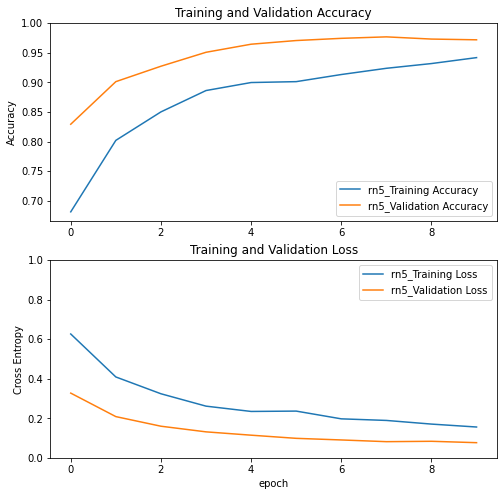

In [328]:
rn5_acc = rn5_history.history['accuracy']
rn5_val_acc = rn5_history.history['val_accuracy']

rn5_loss = rn5_history.history['loss']
rn5_val_loss = rn5_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(rn5_acc, label='rn5_Training Accuracy')
plt.plot(rn5_val_acc, label='rn5_Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(rn5_loss, label='rn5_Training Loss')
plt.plot(rn5_val_loss, label='rn5_Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Fine tuning

In [329]:
rn5_base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(rn5_base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in rn5_base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  175


In [330]:
rn5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [332]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

rn5_history_fine = rn5_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=rn5_history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 18s 170ms/step - loss: 0.1357 - accuracy: 0.9455 - val_loss: 0.0355 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 10s 156ms/step - loss: 0.0882 - accuracy: 0.9635 - val_loss: 0.0316 - val_accuracy: 0.9889
Epoch 12/20
63/63 [==============================] - 10s 158ms/step - loss: 0.0729 - accuracy: 0.9690 - val_loss: 0.0313 - val_accuracy: 0.9901
Epoch 13/20
63/63 [==============================] - 10s 159ms/step - loss: 0.0574 - accuracy: 0.9790 - val_loss: 0.0419 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 10s 154ms/step - loss: 0.0507 - accuracy: 0.9810 - val_loss: 0.0262 - val_accuracy: 0.9926
Epoch 15/20
63/63 [==============================] - 10s 156ms/step - loss: 0.0596 - accuracy: 0.9790 - val_loss: 0.0497 - val_accuracy: 0.9802
Epoch 16/20
63/63 [==============================] - 10s 157ms/step - loss: 0.0386 - accuracy: 0.9855 - val_loss: 0.0424 - val_accuracy:

In [333]:
rn5_acc += rn5_history_fine.history['accuracy']
rn5_val_acc += rn5_history_fine.history['val_accuracy']

rn5_loss += rn5_history_fine.history['loss']
rn5_val_loss += rn5_history_fine.history['val_loss']


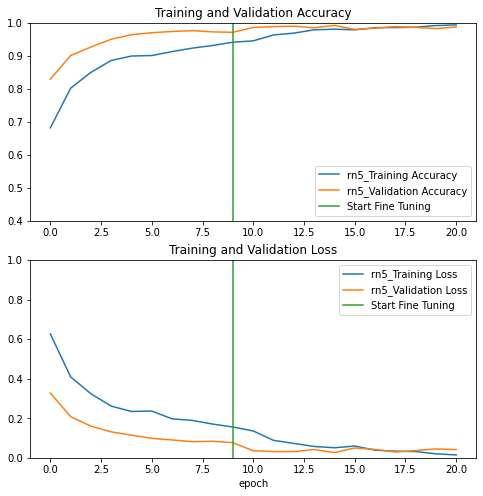

In [334]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(rn5_acc, label='rn5_Training Accuracy')
plt.plot(rn5_val_acc, label='rn5_Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(rn5_loss, label='rn5_Training Loss')
plt.plot(rn5_val_loss, label='rn5_Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [335]:
rn5_loss_, rn5_accuracy = rn5_model.evaluate(test_dataset)
print('Test accuracy :', rn5_accuracy)


6/6 [==============================] - 1s 62ms/step - loss: 0.0340 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


#Comparison

As a comparison of the three different we will plot all the accuracy and loos values in the respective graphs. Which will be very easy to look at for comparison.

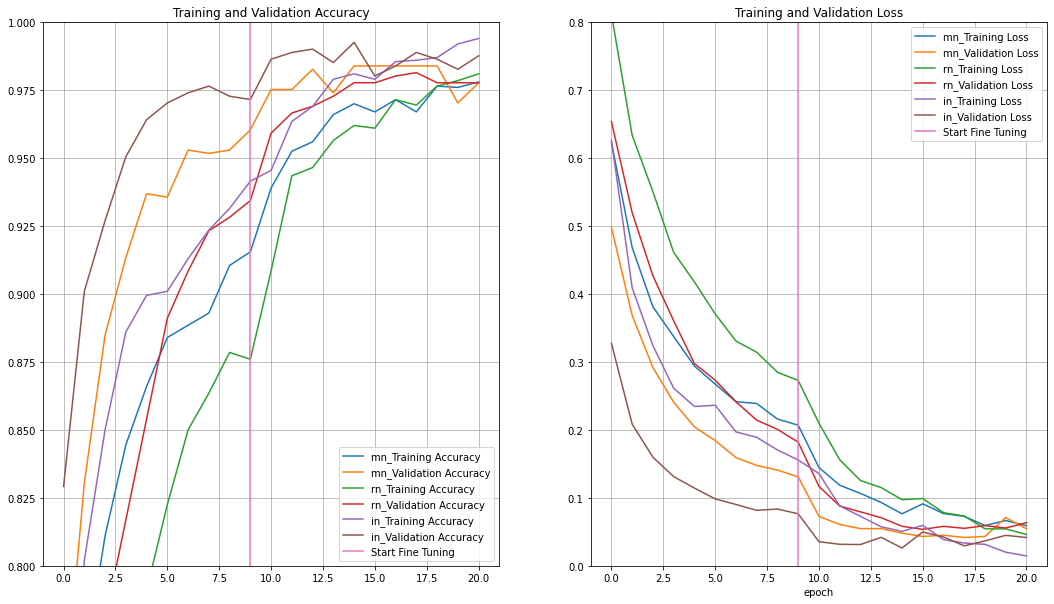

In [344]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='mn_Training Accuracy')
plt.plot(val_acc, label='mn_Validation Accuracy')
plt.plot(mv3_acc, label='rn_Training Accuracy')
plt.plot(mv3_val_acc, label='rn_Validation Accuracy')
plt.plot(rn5_acc, label='in_Training Accuracy')
plt.plot(rn5_val_acc, label='in_Validation Accuracy')
plt.ylim([0.8, 1])
plt.grid(True)
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='mn_Training Loss')
plt.plot(val_loss, label='mn_Validation Loss')
plt.plot(mv3_loss, label='rn_Training Loss')
plt.plot(mv3_val_loss, label='rn_Validation Loss')
plt.plot(rn5_loss, label='in_Training Loss')
plt.plot(rn5_val_loss, label='in_Validation Loss')
plt.ylim([0, 0.8])
plt.grid(True)
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Accuray matrices

As you can see MobileNetV3 is the winner. It shows the highest accuracy on the Test resutls among all three Models.


|                                                | MobileNetV2 | MobileNetV3 | ResNet50 |
|:----------------------------------------------:|:---------:|:------:|:------------:|
| Base model layers | 154 | 263 | 175 |
| Initial accuracy on validation set|54.0%|51.0%|58.0%|
| Validation Accuray (10 epoch)|96.0%|93.0%|97.0%|
| Validation Accuray (fine tuning)|97.7%|97.9%|98.7%|
| Test Accuracy|97.4%|99.5%|99.0%|